# EPU - 국내외

EPU(Economic Policy Uncertainty) Index with KDI Economic Policy Information Database (국내외연구자료)

In [1]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# for colab
"""!pip install konlpy
!git clone https://github.com/SOMJANG/Mecab-ko-for-Google-Colab.git
!cd Mecab-ko-for-Google-Colab
!bash /content/Mecab-ko-for-Google-Colab/install_mecab-ko_on_colab_light_220429.sh
"""

'!pip install konlpy\n!git clone https://github.com/SOMJANG/Mecab-ko-for-Google-Colab.git\n!cd Mecab-ko-for-Google-Colab\n!bash /content/Mecab-ko-for-Google-Colab/install_mecab-ko_on_colab_light_220429.sh\n'

In [3]:
# from konlpy.tag import Mecab
# tagger = Mecab(dicpath=r"C:/mecab/mecab-ko-dic")

# Data Load

In [19]:
import os

folder_path = '../data'
all_files = os.listdir(folder_path)

# 2. "epic_metadata_"로 시작하는 파일 필터링
xlsx_files = [f for f in all_files if f.startswith('research_metadata_') and f.endswith('.xlsx')]

# 3. 각 파일을 읽어서 데이터프레임으로 변환
df_list = []
for file in xlsx_files:
    file_path = os.path.join(folder_path, file)
    df = pd.read_excel(file_path)
    df_list.append(df)

# 4. 모든 데이터프레임을 하나로 연결
combined_df = pd.concat(df_list, ignore_index=True)

# 5. 필요 컬럼만 불러오기
df = combined_df.sort_values('발간일').reset_index(drop=True)[['자료명', '발간일','요약']].reset_index(drop=True)

In [20]:
combined_df.head()

,Unnamed: 0,자료명,발간일,발간처,요약
0,161426,중국농업전망(2021~2030),2022.01.03,한국농촌경제연구원,한국농촌경제연구원이 『중국농업전망(2021~2030)』을 발표하였다.\n\n- 중국...
1,161427,농업회의소 성과평가 및 발전방안,2022.01.03,한국농촌경제연구원,한국농촌경제연구원이 『농업회의소 성과평가 및 발전방안』을 발표하였다.\n\n- 본 ...
2,161428,북한의 당 중앙위원회 제8기 제4차 전원회의 분석,2022.01.03,통일연구원,통일연구원이 『북한의 당 중앙위원회 제8기 제4차 전원회의 분석』을 발표하였다.\n...
3,161429,서울시 청년의 다차원적 빈곤 실태,2022.01.03,서울연구원,서울연구원이 『서울시 청년의 다차원적 빈곤 실태』를 발표하였다.\n\n- 본 연구는...
4,161430,공공투자사업 사회적비용 산정의 쟁점과 대응방안,2022.01.03,서울연구원,서울연구원이 『공공투자사업 사회적비용 산정의 쟁점과 대응방안』을 발표하였다.\n\n...


# Keyword

In [21]:
# '요약' 컬럼에 지정된 단어가 포함되어 있는지 확인하는 함수
def contains_keyword(text):
    if isinstance(text, str):  # Check if the entry is a string
        return int(any(keyword in text for keyword in keywords))
    return 0  # If not a string, return 0

In [59]:
data = df.copy()

# keywords = ['불확실성', '불확실', '위기', '위험', '리스크', '불안', '우려', '걱정'] #EPU_KOR_4

# keywords = ['불확실성', '불확실'] # EPU_baker

keywords = ['불확실성', '불확실', 'uncertain'] # EPU_baker

# keywords = ['불확실', '불안']

In [60]:
# 새로운 컬럼 '불확실여부' 생성
data['불확실여부'] = data['요약'].apply(contains_keyword)

# 인덱스 생성

## 날짜 전처리

In [61]:
# 날짜 형식을 datetime 형식으로 변환하는 함수
def convert_to_datetime(date_str):
    # 'yyyy.mm.' 형식인 경우
    if len(date_str) == 8 and date_str[-1] == '.':
        date_str += '01'
    # 'yyyy.mm.dd' 형식이 아니거나, 잘못된 형식인 경우 None 반환
    elif len(date_str) != 10 or not date_str.replace('.', '').isdigit():
        return None
    
    # 유효하지 않은 일자 확인 및 수정
    try:
        date = pd.to_datetime(date_str, format='%Y.%m.%d', errors='raise')
        # 유효하지 않은 월이나 일을 가진 경우 None 반환
        if date.month == 0 or date.day == 0:
            return None
    except ValueError:
        # 잘못된 날짜는 'yyyy.mm.01'로 수정
        date_str = date_str[:8] + '01'
        try:
            date = pd.to_datetime(date_str, format='%Y.%m.%d')
        except ValueError:
            return None
    return date

In [62]:
# '발간일' 컬럼을 datetime 형식으로 변환
data['발간일'] = data['발간일'].apply(convert_to_datetime)

# 필요 날짜만 고르자.
data = data[(data['발간일'] >= '2022-01-01') & (data['발간일'] <= '2024-05-30')]

## EPU Index 생성

In [63]:
def daily_epu(data):
    # 일별로 자료 총 건수와 불확실여부가 1인 자료 건수를 구함
    daily_counts = data.groupby(data['발간일'].dt.date)['불확실여부'].agg(['count', 'sum'])
    daily_counts.columns = ['total_count', 'uncertainty_count']
    
    # 불확실도 계산 (불확실여부가 1인 자료 건수 / 총 자료 건수)
    daily_counts['불확실도'] = daily_counts['uncertainty_count'] / daily_counts['total_count']
    
    # 1) 불확실도를 계산한 데이터프레임을 날짜를 인덱스로 설정
    daily_uncertainty_index = daily_counts['불확실도']
    return daily_uncertainty_index

In [64]:
def monthly_epu(data):
    # 월별로 자료 총 건수와 불확실여부가 1인 자료 건수를 구함
    monthly_counts = data.groupby(data['발간일'].dt.to_period('M'))['불확실여부'].agg(['count', 'sum'])
    monthly_counts.columns = ['total_count', 'uncertainty_count']
    
    # 불확실도 계산 (불확실여부가 1인 자료 건수 / 총 자료 건수)
    monthly_counts['불확실도'] = monthly_counts['uncertainty_count'] / monthly_counts['total_count']
    
    # 1) 불확실도를 계산한 데이터프레임을 월을 인덱스로 설정
    monthly_uncertainty_index = monthly_counts['불확실도']
    return monthly_uncertainty_index
# 2) 불확실건수로
# monthly_uncertainty_index = monthly_counts['uncertainty_count']

In [65]:
daily_uncertainty_index = daily_epu(data)
monthly_uncertainty_index = monthly_epu(data)

# Visualize

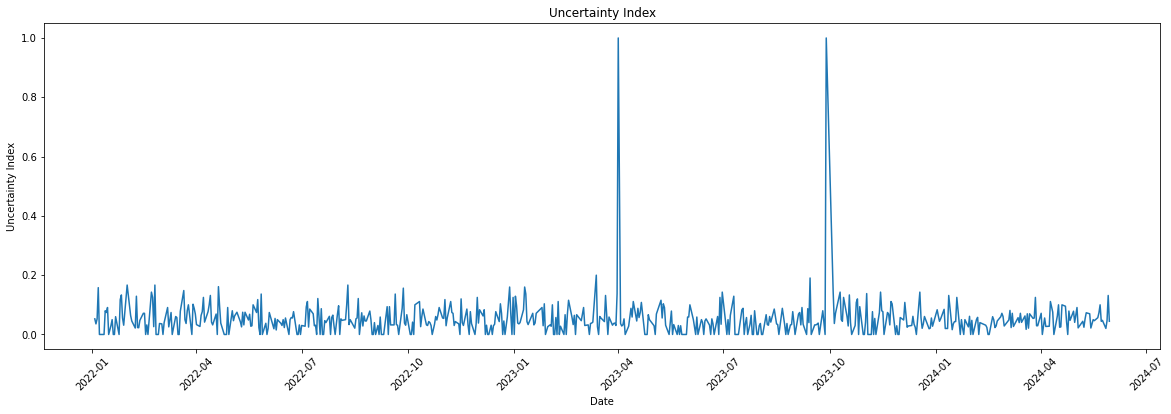

In [66]:
# 선 그래프 그리기
plt.figure(figsize=(20, 6))
daily_uncertainty_index.plot()
plt.title('Uncertainty Index')
plt.xlabel('Date')
plt.ylabel('Uncertainty Index')
plt.xticks(rotation=45)
plt.show()

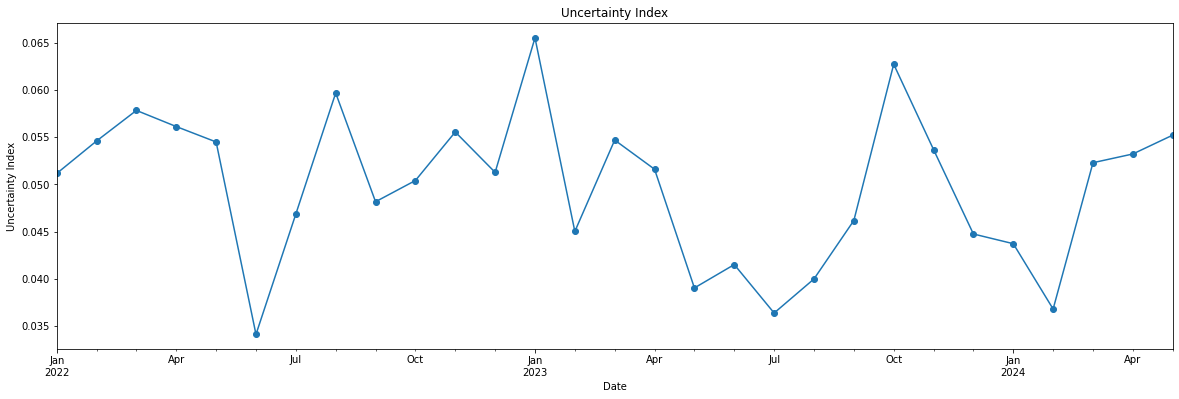

In [67]:
# 선 그래프 그리기
plt.figure(figsize=(20, 6))
monthly_uncertainty_index.plot(marker='o')
plt.title('Uncertainty Index')
plt.xlabel('Date')
plt.ylabel('Uncertainty Index')

plt.show()

In [68]:
data

,자료명,발간일,요약,불확실여부
2152,중국농업전망(2021~2030),2022-01-03,한국농촌경제연구원이 『중국농업전망(2021~2030)』을 발표하였다.\n\n- 중국...,0
2153,Climate-smart agriculture and the World Trade ...,2022-01-03,Climate change threatens global food security ...,0
2154,섬유산업의 글로벌 메가트렌드 변화와 대응 전략,2022-01-03,산업연구원이 『섬유산업의 글로벌 메가트렌드 변화와 대응 전략』을 발표하였다.\n\n...,0
2155,2022년 중국 경제전망 및 시사점,2022-01-03,대한무역투자진흥공사가 『2022년 중국 경제전망 및 시사점』을 발표하였다.\n\n-...,0
2156,[KEI Research Briefs Vol.9 No.3] Integrated Wa...,2022-01-03,CONTENTS\n\n- Issues and Policy Directions tow...,0
...,...,...,...,...
22207,Sustainability initiatives and responsible bus...,2024-05-30,This paper analyses of the use of sustainabili...,0
22208,The status of women in agrifood systems,2024-05-30,The status of women in agrifood systems report...,0
22209,Codex Alimentarius Commission Procedural Manual,2024-05-30,The Procedural Manual of the Codex Alimentariu...,0
22210,Household inflation expectiations: an overview...,2024-05-30,This paper discusses the recent wave of resear...,0
